In [1]:
import os
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns

sns.reset_orig()
sns.set()

import random


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision import transforms

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data import Subset

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [3]:
class TraficDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

In [4]:
dataset = datasets.ImageFolder(root="data")
trafic_dataset = TraficDataset(dataset, transform=transforms.ToTensor())


def get_train_images(num):
    return torch.stack(
        [trafic_dataset[random.randint(0, 20000)][0] for i in range(10, 10 + num)],
        dim=0,
    )

In [5]:
normalize_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=mean, std=std),
    ]
)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
torch.manual_seed(73)
n_train_examples = int(len(dataset) * 0.9)
train_indices, validation_indices = random_split(
    range(len(dataset)), [n_train_examples, len(dataset) - n_train_examples]
)

validation_dataset = TraficDataset(
    Subset(dataset, validation_indices), transform=normalize_transform
)
train_dataset = TraficDataset(
    Subset(dataset, train_indices), transform=normalize_transform
)

validation_loader = DataLoader(
    validation_dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=10
)
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=10,
)

In [101]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(
            torch.randn([n_imgs, model.latent_dim]).to(device)
        )
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=8, normalize=False)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

In [7]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

# VAE

In [311]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=3
        )
        self.conv4 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2
        )
        # self.conv5 = nn.Conv2d(
        #     in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2
        # )
        # self.conv6 = nn.Conv2d(
        #     in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        # )
        self.fc_1 = nn.Linear(64 * 32 * 32, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # x = F.leaky_relu(self.conv5(x))
        # x = F.leaky_relu(self.conv6(x))
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=3,
            kernel_size=7,
            output_padding=0,
            padding=3,
            stride=1,
        )
        self.conv2 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=32,
            kernel_size=7,
            output_padding=0,
            padding=3,
            stride=1,
        )
        self.conv3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=5,
            output_padding=0,
            padding=2,
            stride=1,
        )
        # self.conv4 = nn.ConvTranspose2d(
        #     in_channels=32,
        #     out_channels=16,
        #     kernel_size=5,
        #     output_padding=1,
        #     padding=2,
        #     stride=2,
        # )
        # self.conv5 = nn.ConvTranspose2d(
        #     in_channels=16,
        #     out_channels=3,
        #     kernel_size=3,
        #     output_padding=0,
        #     padding=1,
        #     stride=1,
        # )
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 64 * 32 * 32)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 64, 32, 32])
        x_hat = F.leaky_relu(self.conv3(x_hat))
        x_hat = F.leaky_relu(self.conv2(x_hat))
        x_hat = F.leaky_relu(self.conv1(x_hat))
        # x_hat = F.leaky_relu(self.conv4(x_hat))
        # x_hat = F.leaky_relu(self.conv5(x_hat))
        return x_hat

In [312]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(
            input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim
        )
        self.decoder = Decoder(
            latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim
        )

    def reparameterization(self, mean, var):
        # Change to proper sampling
        z = torch.randn_like(mean) * var + mean
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(
            mean, torch.exp(0.5 * log_var)
        )  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [313]:
vae = VAE(latent_dim=128, hidden_dim=512, x_dim=3072).to(device)
vae

VAE(
  (encoder): Encoder(
    (conv2): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (fc_1): Linear(in_features=65536, out_features=512, bias=True)
    (fc_2): Linear(in_features=512, out_features=512, bias=True)
    (fc_mean): Linear(in_features=512, out_features=128, bias=True)
    (fc_var): Linear(in_features=512, out_features=128, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(32, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv2): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (fc_1): Linear(in_features=128, out_features=512, bias=True)
    (fc_2): Linear(in_features=512, out_features=512, bias=True)
    

In [314]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [343]:
optimizer = optim.Adam(vae.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [344]:
num_epochs = 100
for n in range(num_epochs):
    vae.train()
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    L1_list = []

    vae.eval()
    for x, _ in iter(validation_loader):
        x = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(
        f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, Validation L1 = {np.mean(L1_list)}"
    )
    scheduler.step()

Epoch 0 loss 9729.409892506843, Validation L1 = 0.06628976861635844
Epoch 1 loss 8377.139534386406, Validation L1 = 0.06662949323654174
Epoch 2 loss 8413.610732920848, Validation L1 = 0.06702447533607483
Epoch 3 loss 8444.799245124315, Validation L1 = 0.0667372743288676
Epoch 4 loss 8434.566192404198, Validation L1 = 0.06645240808526674
Epoch 5 loss 8428.650804060218, Validation L1 = 0.0666178905715545
Epoch 6 loss 8421.39177620324, Validation L1 = 0.06687345194319884
Epoch 7 loss 8387.284054944115, Validation L1 = 0.06665072217583656
Epoch 8 loss 8395.083332145301, Validation L1 = 0.0670407789448897
Epoch 9 loss 8377.756671989051, Validation L1 = 0.06669462919235229
Epoch 10 loss 8324.92384950958, Validation L1 = 0.06676601581275463
Epoch 11 loss 8327.851330833713, Validation L1 = 0.06670420294006665
Epoch 12 loss 8315.446417369982, Validation L1 = 0.06674927485485872
Epoch 13 loss 8310.778049441149, Validation L1 = 0.06672215312719346
Epoch 14 loss 8299.883828267564, Validation L1 = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


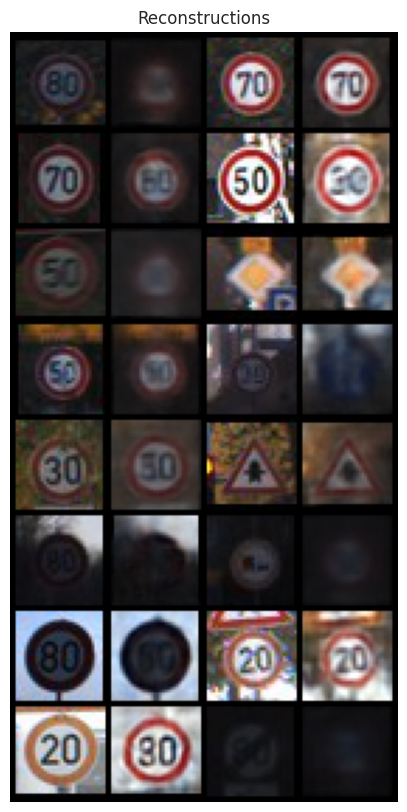

In [345]:
input_imgs = get_train_images(16)
vae.eval()
visualize_reconstructions(vae, input_imgs, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


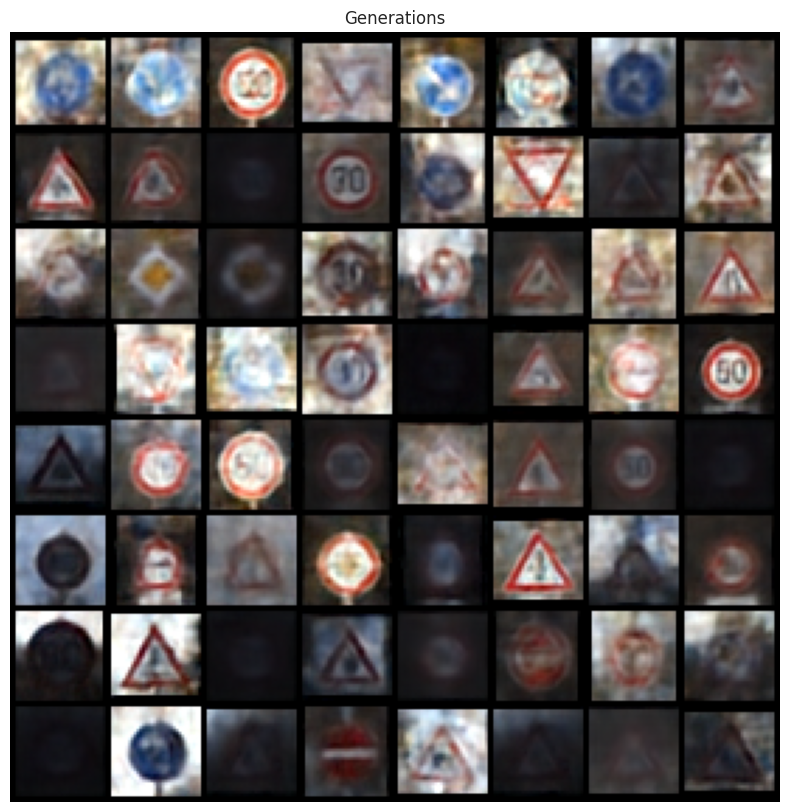

In [346]:
vae.eval()
generate_images(vae, 64, device)

In [378]:
torch.save(vae, "even_better_to_train.model")

# GAN

In [49]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2
        )
        self.fc_1 = nn.Linear(32*16*16, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [50]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 32*16*16)

        self.conv2 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=3,
            kernel_size=5,
            output_padding=1,
            padding=2,
            stride=2,
        )

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 32, 16, 16])
        x_hat = F.leaky_relu(self.conv2(x_hat))
        return x_hat

In [55]:
latent_dim = 128
generator = Generator(latent_dim=latent_dim, hidden_dim=1028, output_dim=32*32*3).to(device)
generator.train()
discriminator = Discriminator( hidden_dim=2056, input_dim=32*32*3).to(device)
discriminator.train()

Discriminator(
  (conv2): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc_1): Linear(in_features=8192, out_features=2056, bias=True)
  (fc_2): Linear(in_features=2056, out_features=2056, bias=True)
  (fc_out): Linear(in_features=2056, out_features=1, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [56]:

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()
fixed_noise = torch.randn(16, latent_dim,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, discrimiantor fake error: 0.0346, discriminator real acc: 0.955


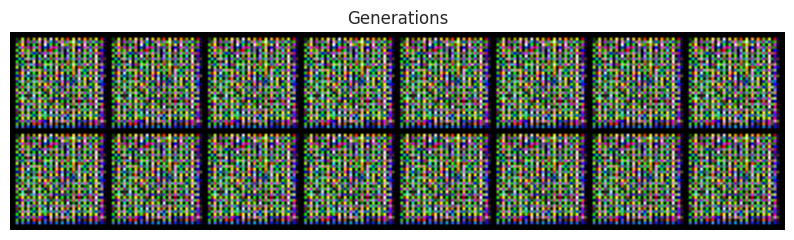

Epoch: 1, discrimiantor fake error: 0.00633, discriminator real acc: 0.986
Epoch: 2, discrimiantor fake error: 0.00372, discriminator real acc: 0.993
Epoch: 3, discrimiantor fake error: 0.00336, discriminator real acc: 0.995
Epoch: 4, discrimiantor fake error: 0.0022, discriminator real acc: 0.997
Epoch: 5, discrimiantor fake error: 0.00192, discriminator real acc: 0.998
Epoch: 6, discrimiantor fake error: 0.00136, discriminator real acc: 0.998
Epoch: 7, discrimiantor fake error: 0.000551, discriminator real acc: 0.999
Epoch: 8, discrimiantor fake error: 0.000392, discriminator real acc: 0.999
Epoch: 9, discrimiantor fake error: 0.00108, discriminator real acc: 0.998
Epoch: 10, discrimiantor fake error: 0.000896, discriminator real acc: 0.999
Epoch: 11, discrimiantor fake error: 0.00101, discriminator real acc: 0.999
Epoch: 12, discrimiantor fake error: 0.0012, discriminator real acc: 0.998
Epoch: 13, discrimiantor fake error: 0.00171, discriminator real acc: 0.999
Epoch: 14, discrimia

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20, discrimiantor fake error: 0.00044, discriminator real acc: 0.999


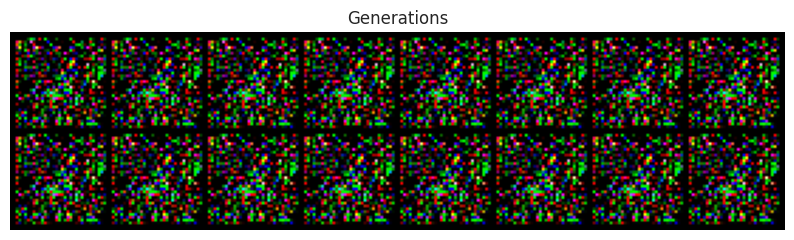

Epoch: 21, discrimiantor fake error: 0.000284, discriminator real acc: 0.999
Epoch: 22, discrimiantor fake error: 0.000297, discriminator real acc: 0.999
Epoch: 23, discrimiantor fake error: 0.000255, discriminator real acc: 0.998
Epoch: 24, discrimiantor fake error: 0.00129, discriminator real acc: 0.999
Epoch: 25, discrimiantor fake error: 0.000553, discriminator real acc: 0.999
Epoch: 26, discrimiantor fake error: 0.0013, discriminator real acc: 0.998
Epoch: 27, discrimiantor fake error: 0.00139, discriminator real acc: 0.999
Epoch: 28, discrimiantor fake error: 0.000838, discriminator real acc: 0.999
Epoch: 29, discrimiantor fake error: 0.000557, discriminator real acc: 0.999
Epoch: 30, discrimiantor fake error: 0.000574, discriminator real acc: 1.0
Epoch: 31, discrimiantor fake error: 0.00031, discriminator real acc: 1.0
Epoch: 32, discrimiantor fake error: 0.00024, discriminator real acc: 1.0
Epoch: 33, discrimiantor fake error: 0.000141, discriminator real acc: 1.0
Epoch: 34, di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 40, discrimiantor fake error: 4.35e-05, discriminator real acc: 1.0


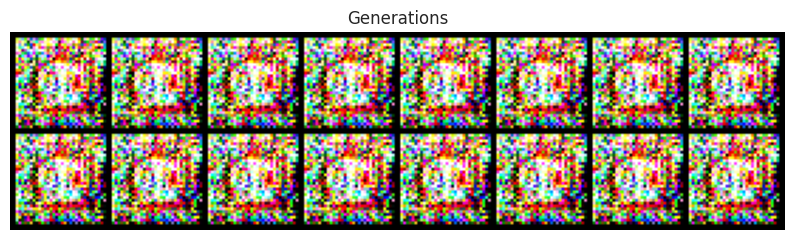

Epoch: 41, discrimiantor fake error: 9.8e-05, discriminator real acc: 1.0
Epoch: 42, discrimiantor fake error: 0.00013, discriminator real acc: 1.0
Epoch: 43, discrimiantor fake error: 0.000116, discriminator real acc: 1.0
Epoch: 44, discrimiantor fake error: 8.79e-05, discriminator real acc: 1.0
Epoch: 45, discrimiantor fake error: 0.000106, discriminator real acc: 1.0
Epoch: 46, discrimiantor fake error: 0.000121, discriminator real acc: 1.0
Epoch: 47, discrimiantor fake error: 0.000159, discriminator real acc: 1.0
Epoch: 48, discrimiantor fake error: 0.000139, discriminator real acc: 1.0
Epoch: 49, discrimiantor fake error: 0.000331, discriminator real acc: 1.0
Epoch: 50, discrimiantor fake error: 0.000615, discriminator real acc: 0.999
Epoch: 51, discrimiantor fake error: 0.000557, discriminator real acc: 0.999
Epoch: 52, discrimiantor fake error: 0.000131, discriminator real acc: 1.0
Epoch: 53, discrimiantor fake error: 0.000103, discriminator real acc: 1.0
Epoch: 54, discrimianto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 60, discrimiantor fake error: 0.000123, discriminator real acc: 1.0


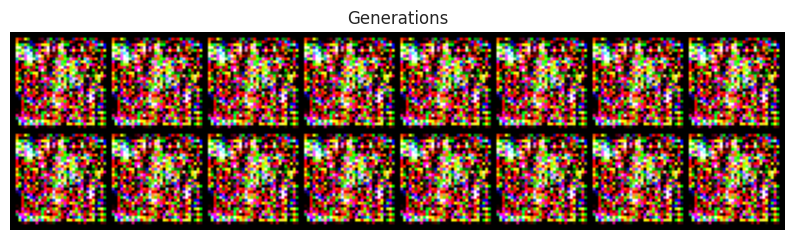

Epoch: 61, discrimiantor fake error: 9.14e-05, discriminator real acc: 1.0
Epoch: 62, discrimiantor fake error: 7.03e-05, discriminator real acc: 1.0
Epoch: 63, discrimiantor fake error: 8.86e-05, discriminator real acc: 1.0
Epoch: 64, discrimiantor fake error: 7.25e-05, discriminator real acc: 1.0
Epoch: 65, discrimiantor fake error: 6.06e-05, discriminator real acc: 1.0
Epoch: 66, discrimiantor fake error: 3.3e-05, discriminator real acc: 1.0
Epoch: 67, discrimiantor fake error: 0.000117, discriminator real acc: 1.0
Epoch: 68, discrimiantor fake error: 0.000126, discriminator real acc: 1.0
Epoch: 69, discrimiantor fake error: 0.000216, discriminator real acc: 1.0
Epoch: 70, discrimiantor fake error: 0.00027, discriminator real acc: 1.0
Epoch: 71, discrimiantor fake error: 0.000213, discriminator real acc: 1.0
Epoch: 72, discrimiantor fake error: 0.00017, discriminator real acc: 1.0
Epoch: 73, discrimiantor fake error: 6.92e-05, discriminator real acc: 1.0
Epoch: 74, discrimiantor fak

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 80, discrimiantor fake error: 0.000167, discriminator real acc: 1.0


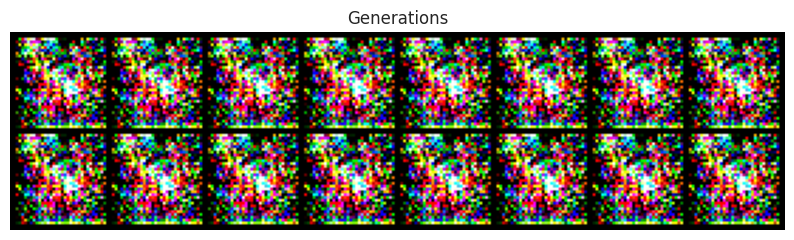

Epoch: 81, discrimiantor fake error: 0.000118, discriminator real acc: 1.0
Epoch: 82, discrimiantor fake error: 0.000204, discriminator real acc: 1.0
Epoch: 83, discrimiantor fake error: 0.000247, discriminator real acc: 1.0
Epoch: 84, discrimiantor fake error: 0.000255, discriminator real acc: 1.0
Epoch: 85, discrimiantor fake error: 0.000306, discriminator real acc: 1.0
Epoch: 86, discrimiantor fake error: 0.000193, discriminator real acc: 1.0
Epoch: 87, discrimiantor fake error: 0.000219, discriminator real acc: 1.0
Epoch: 88, discrimiantor fake error: 0.000102, discriminator real acc: 1.0
Epoch: 89, discrimiantor fake error: 0.000162, discriminator real acc: 1.0
Epoch: 90, discrimiantor fake error: 5.33e-05, discriminator real acc: 1.0
Epoch: 91, discrimiantor fake error: 0.000133, discriminator real acc: 1.0
Epoch: 92, discrimiantor fake error: 0.000113, discriminator real acc: 1.0
Epoch: 93, discrimiantor fake error: 0.000146, discriminator real acc: 1.0
Epoch: 94, discrimiantor 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 100, discrimiantor fake error: 7.53e-05, discriminator real acc: 1.0


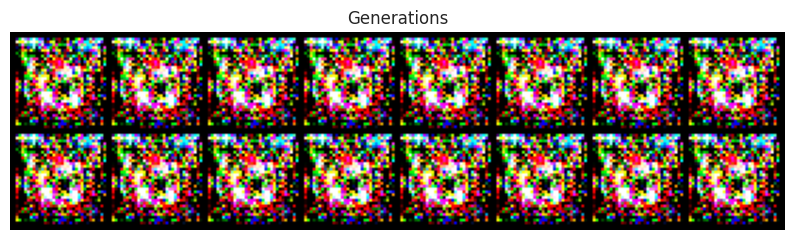

Epoch: 101, discrimiantor fake error: 5.2e-05, discriminator real acc: 1.0
Epoch: 102, discrimiantor fake error: 0.000105, discriminator real acc: 1.0
Epoch: 103, discrimiantor fake error: 0.000144, discriminator real acc: 1.0
Epoch: 104, discrimiantor fake error: 3.45e-05, discriminator real acc: 1.0
Epoch: 105, discrimiantor fake error: 0.000105, discriminator real acc: 1.0
Epoch: 106, discrimiantor fake error: 0.000135, discriminator real acc: 1.0
Epoch: 107, discrimiantor fake error: -3.46e-05, discriminator real acc: 1.0
Epoch: 108, discrimiantor fake error: 0.00023, discriminator real acc: 1.0
Epoch: 109, discrimiantor fake error: 0.000176, discriminator real acc: 1.0
Epoch: 110, discrimiantor fake error: 9.71e-05, discriminator real acc: 1.0
Epoch: 111, discrimiantor fake error: 0.000146, discriminator real acc: 1.0
Epoch: 112, discrimiantor fake error: 3.37e-05, discriminator real acc: 1.0
Epoch: 113, discrimiantor fake error: 7.02e-05, discriminator real acc: 1.0
Epoch: 114, d

In [57]:
G_losses = []
D_losses = []
num_epochs = 120
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 20 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [58]:
test_noise = torch.randn(64, latent_dim,device=device)

with torch.no_grad():
    fake = generator(test_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# GLOW

# VAEGAN

VAEGAN jest niepoprawnie zrobiony

In [33]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0
        )
        self.conv3 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2
        )
        self.conv4 = nn.Conv2d(
            in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1
        )
        self.fc_1 = nn.Linear(128 * 8 * 8, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.conv2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=32,
            kernel_size=3,
            output_padding=1,
            padding=1,
            stride=2,
        )
        self.conv3 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=16,
            kernel_size=5,
            output_padding=0,
            padding=2,
            stride=1,
        )
        self.conv4 = nn.ConvTranspose2d(
            in_channels=16,
            out_channels=3,
            kernel_size=3,
            output_padding=1,
            padding=1,
            stride=2,
        )
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 128 * 8 * 8)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 128, 8, 8])
        x_hat = F.leaky_relu(self.conv2(x_hat))
        x_hat = F.leaky_relu(self.conv3(x_hat))
        x_hat = F.leaky_relu(self.conv4(x_hat))
        return x_hat


class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [ ]:
class VaeGan(nn.Module):
    def __init__(self):
        self.encoder = Encoder(hidden_dim=1024, latent_dim=256)
        self.decoder = Decoder(hidden_dim=1024, latent_dim=256)
        self.discriminator = Discriminator()

In [43]:
def reparameterization(mean, var):
    z = torch.randn_like(mean) * var + mean
    return z

In [46]:
encoder = Encoder(hidden_dim=1024, latent_dim=128).to(device)
decoder = Decoder(hidden_dim=1024, latent_dim=128).to(device)
discriminator = Discriminator(128, 1024).to(device)

In [40]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [41]:
encoder_optimizer = optim.Adam(vae.parameters(), lr=0.00005)
encoder_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=encoder_optimizer, gamma=0.99)
decoder_optimizer = optim.Adam(vae.parameters(), lr=0.00005)
decoder_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=decoder_optimizer, gamma=0.99)

criterion = nn.MSELoss()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

In [49]:
num_epochs = 50

laten_dim = 128
gamma = 0.5

for n in range(num_epochs):
    encoder.train()
    decoder.train()
    discriminator.train()
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        mean, log_var = encoder(x)
        decoded_img = decoder(reparameterization(
            mean, torch.exp(0.5 * log_var)
        ))
        fake_img = decoder(torch.randn([x.shape[0], laten_dim]).to(device))
        loss = vae_loss_function(x, decoded_img, means, log_var)



        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake

        error_decoder = -error_discriminator + gamma*loss

        error_discriminator.backward()
        error_decoder.backwards()
        loss.backward()
        # Update D
        discriminator_optimizer.step()
        encoder_optimizer.step()
        decoder_optimizer.step()



    L1_list = []
    #     if n % 10 == 0:
    # vae.eval()
    # for x, _ in iter(validation_loader):
    #     x = x.to(device)
    #     out, _, _ = vae(x)
    #     L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(
        f"Epoch {n} loss {loss}, {error_decoder}, {error_discriminator}"
    )
    discriminator_scheduler.step()
    encoder_scheduler.step()
    decoder_scheduler.step()

ERROR:tornado.general:SEND Error: Host unreachable


# Plot Laten

In [381]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [382]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0, n_data, 40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))

    sns.scatterplot(
        x=0,
        y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1,
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(
            OffsetImage(example, cmap=plt.cm.gray_r, zoom=1),
            (x, y),
            frameon=True,
            bboxprops=dict(
                facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"
            ),
        )
        ax.add_artist(ab)
    plt.show()

In [383]:
def embed_imgs(model, data_loader):

    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (
        torch.cat(img_list, dim=0),
        torch.cat(embed_list, dim=0),
        torch.cat(labels, dim=0),
    )

In [384]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
# test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())
plot_latent(train_embedded, train_img_embeds)

KeyboardInterrupt: 

# LOAD VAE

In [175]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=3
        )
        self.conv4 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2
        )
        # self.conv5 = nn.Conv2d(
        #     in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2
        # )
        # self.conv6 = nn.Conv2d(
        #     in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        # )
        self.fc_1 = nn.Linear(64 * 32 * 32, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # x = F.leaky_relu(self.conv5(x))
        # x = F.leaky_relu(self.conv6(x))
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=3,
            kernel_size=7,
            output_padding=0,
            padding=3,
            stride=1,
        )
        self.conv2 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=32,
            kernel_size=7,
            output_padding=0,
            padding=3,
            stride=1,
        )
        self.conv3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=5,
            output_padding=0,
            padding=2,
            stride=1,
        )
        # self.conv4 = nn.ConvTranspose2d(
        #     in_channels=32,
        #     out_channels=16,
        #     kernel_size=5,
        #     output_padding=1,
        #     padding=2,
        #     stride=2,
        # )
        # self.conv5 = nn.ConvTranspose2d(
        #     in_channels=16,
        #     out_channels=3,
        #     kernel_size=3,
        #     output_padding=0,
        #     padding=1,
        #     stride=1,
        # )
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 64 * 32 * 32)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 64, 32, 32])
        x_hat = F.leaky_relu(self.conv3(x_hat))
        x_hat = F.leaky_relu(self.conv2(x_hat))
        x_hat = F.leaky_relu(self.conv1(x_hat))
        # x_hat = F.leaky_relu(self.conv4(x_hat))
        # x_hat = F.leaky_relu(self.conv5(x_hat))
        return x_hat


class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(
            input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim
        )
        self.decoder = Decoder(
            latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim
        )

    def reparameterization(self, mean, var):
        # Change to proper sampling
        z = torch.randn_like(mean) * var + mean
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(
            mean, torch.exp(0.5 * log_var)
        )  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [379]:
vae = torch.load("even_better_to_train.model").to(device)
vae

VAE(
  (encoder): Encoder(
    (conv2): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (fc_1): Linear(in_features=65536, out_features=512, bias=True)
    (fc_2): Linear(in_features=512, out_features=512, bias=True)
    (fc_mean): Linear(in_features=512, out_features=128, bias=True)
    (fc_var): Linear(in_features=512, out_features=128, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(32, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv2): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (fc_1): Linear(in_features=128, out_features=512, bias=True)
    (fc_2): Linear(in_features=512, out_features=512, bias=True)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


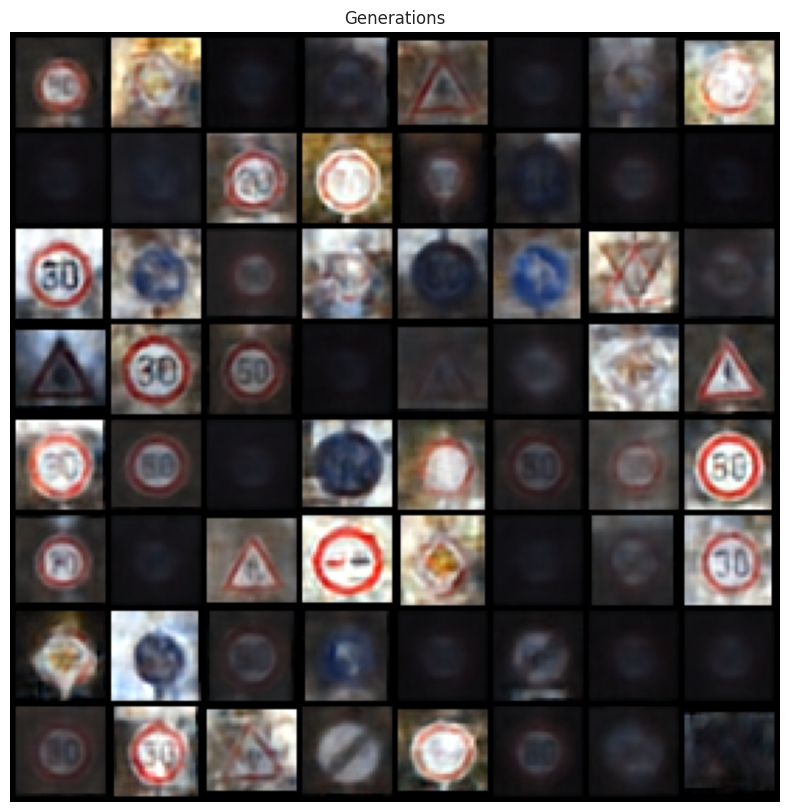

In [380]:
vae.eval()
generate_images(vae, 64, device)

In [ ]:
latent_dim = 128

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = generator(fixed_noise)
    # generations_vae = denormalize(generations_vae)
    print(generations_vae.shape)

torch.save(generations_vae.cpu().detach(),"poniedzialek_Chomanski_Młynik.pt")

# Evaluator

In [19]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [20]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out = nn.Linear(50, 43)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x


evaluator = Evaluator(32 * 32 * 3, 256).to(device)

In [21]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)

# loss
criterion = nn.CrossEntropyLoss()

In [22]:
num_epochs = 15
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data, targets = data.to(device), targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [23]:
correct = 0
guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(validation_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        correct += torch.eq(targets, best_guesses).sum().item()
        guesses += len(targets)

print("Correctly guessed ", correct / guesses * 100, "% of the dataset")

Correctly guessed  93.75 % of the dataset


## VAE

In [394]:
generations_vae = torch.load("poniedzialek_Chomanski_Młynik_bez_norm_109.pt").to(device)

In [374]:
latent_dim = 128

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = vae.decoder(fixed_noise)
    # generations_vae = denormalize(generations_vae)
    print(generations_vae.shape)

torch.Size([1000, 3, 32, 32])


In [395]:
orig_data = [x[0] for x in list(validation_dataset)[:1000]]
orig_data = torch.tensor(np.array(orig_data))
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [396]:
calculate_frechet_distance(dist_orig_data.numpy(), dist_vae.numpy())

114.38694346525062

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


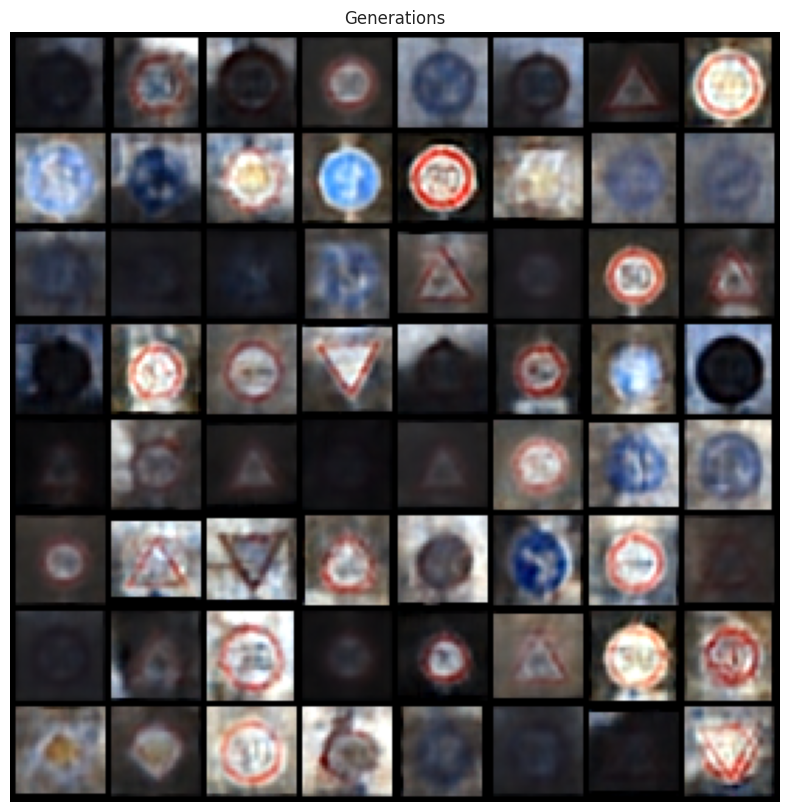

In [397]:
grid = torchvision.utils.make_grid(generations_vae[-64:].cpu(), nrow=8, normalize=False)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(15, 10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis("off")
plt.show()

In [330]:
torch.save(generations_vae.cpu().detach(),"poniedzialek_Chomanski_Młynik_bez_norm_112.pt")

## GAN

In [113]:
latent_dim = 128

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = generator(fixed_noise)
    # generations_vae = denormalize(generations_vae)
    print(generations_vae.shape)

NameError: name 'generator' is not defined

In [65]:
orig_data = [x[0] for x in list(validation_dataset)[:1000]]
orig_data = torch.tensor(np.array(orig_data))
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [66]:
calculate_frechet_distance(dist_orig_data.numpy(), dist_vae.numpy())

8260.244471586911